## Unet Camvid model

In [15]:
%matplotlib inline
import matplotlib.pyplot as plt

import keras
import numpy as np
import tensorflow as tf

import pickle 
import glob
import threading
import random
import bcolz
import os
from PIL import Image


from keras.models import Model, Sequential, load_model
from keras.layers import *
from keras.optimizers import *


In [16]:
print(keras.__version__)

2.0.6


## Making the dataset

In [17]:
#path = '../input/camvid-master/'
path = './camvid/camvid-master/'

In [18]:
images_path = path + '701_StillsRaw_full/'
labels_path = path + 'LabeledApproved_full/'

### Getting the images - not needed when loading

In [19]:
images = glob.glob(images_path + '*.png')
print (images[:3])

labels = [labels_path + os.path.basename(i)[:-4] + '_L.png' for i in images]
print (labels[:3])

['./camvid/camvid-master/701_StillsRaw_full/Seq05VD_f01680.png', './camvid/camvid-master/701_StillsRaw_full/0016E5_05370.png', './camvid/camvid-master/701_StillsRaw_full/0016E5_00870.png']
['./camvid/camvid-master/LabeledApproved_full/Seq05VD_f01680_L.png', './camvid/camvid-master/LabeledApproved_full/0016E5_05370_L.png', './camvid/camvid-master/LabeledApproved_full/0016E5_00870_L.png']


In [20]:
image_size = (480,360)

In [21]:
def open_image(img):
    return np.array(Image.open(img).resize(image_size, Image.NEAREST))

In [22]:
imgs = np.stack([open_image(i) for i in images])
imgs.shape

(701, 360, 480, 3)

In [23]:
lbs = np.stack([open_image(l) for l in labels])
lbs.shape

(701, 360, 480, 3)

## Normalize the images

In [24]:
imgs = imgs/255.

In [25]:
mean = imgs.mean() 
std = imgs.std()
mean, std

(0.39996644266360942, 0.30179491142291076)

In [26]:
imgs-=imgs.mean()
imgs/=imgs.std()

## Save the images to Bcolz array

In [27]:
def save_array(fname, arr):
    c=bcolz.carray(arr, rootdir=fname, mode='w')
    c.flush()

def load_array(fname): return bcolz.open(fname)[:]

In [18]:
save_array('imgs.bc', imgs)
save_array('lbs.bc', lbs)


### needed when loading 

In [28]:
imgs = load_array('imgs.bc')
lbs = load_array('lbs.bc')

In [29]:
class BatchIndices(object):
    def __init__(self, n, bs, shuffle=False):
        self.n,self.bs,self.shuffle = n,bs,shuffle
        self.lock = threading.Lock()
        self.reset()

    def reset(self):
        self.idxs = (np.random.permutation(self.n) 
                     if self.shuffle else np.arange(0, self.n))
        self.curr = 0

    def __next__(self):
        with self.lock:
            if self.curr >= self.n: self.reset()
            ni = min(self.bs, self.n-self.curr)
            res = self.idxs[self.curr:self.curr+ni]
            self.curr += ni
            return res

In [30]:
bi = BatchIndices(10,3, True)
[next(bi) for o in range(5)]

[array([7, 0, 3]),
 array([2, 4, 9]),
 array([1, 5, 8]),
 array([6]),
 array([9, 5, 2])]

In [31]:
class segm_generator(object):
    def __init__(self, x, y, bs=64, out_sz=(224,224), train=True):
        self.x, self.y, self.bs, self.train = x,y,bs,train
        self.n, self.ri, self.ci, _ = x.shape
        self.idx_gen = BatchIndices(self.n, bs, train)
        self.ro, self.co = out_sz
        self.ych = self.y.shape[-1] if len(y.shape)==4 else 1

    def get_slice(self, i,o):
        start = random.randint(0, i-o) if self.train else (i-o)
        return slice(start, start+o)

    def get_item(self, idx):
        slice_r = self.get_slice(self.ri, self.ro)
        slice_c = self.get_slice(self.ci, self.co)
        x = self.x[idx, slice_r, slice_c]
        y = self.y[idx, slice_r, slice_c]
        if self.train and (random.random()>0.5): 
            y = y[:,::-1]
            x = x[:,::-1]
        return x, y

    def __next__(self):
        idxs = next(self.idx_gen)
        items = (self.get_item(idx) for idx in idxs)
        xs,ys = zip(*items)
        return np.stack(xs), np.stack(ys).reshape(len(ys), -1, self.ych)

In [32]:
sg = segm_generator(imgs, lbs, 4, train=False)
b_img, b_label = next(sg)

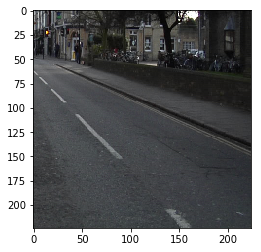

In [33]:
plt.imshow(b_img[0]*0.3+0.4);

## Making labels

In [34]:
def parse_code(l):
    if len(l.strip().split("\t")) == 2:
        a, b = l.strip().split("\t")
        return tuple(int(i) for i in a.split(' ')), b
    else:
        a, b, c = l.strip().split("\t")
        return tuple(int(i) for i in a.split(' ')), c

In [35]:
label_codes, label_names = zip(*[parse_code(l) for l in open(path+"label_colors.txt")])
label_codes, label_names = list(label_codes), list(label_names)
label_codes[:5], label_names[:5]

len(label_names)

32

## The Labels

In [36]:
for i in range(len(label_names)):
    print(label_codes[i],label_names[i])


(64, 128, 64) Animal
(192, 0, 128) Archway
(0, 128, 192) Bicyclist
(0, 128, 64) Bridge
(128, 0, 0) Building
(64, 0, 128) Car
(64, 0, 192) CartLuggagePram
(192, 128, 64) Child
(192, 192, 128) Column_Pole
(64, 64, 128) Fence
(128, 0, 192) LaneMkgsDriv
(192, 0, 64) LaneMkgsNonDriv
(128, 128, 64) Misc_Text
(192, 0, 192) MotorcycleScooter
(128, 64, 64) OtherMoving
(64, 192, 128) ParkingBlock
(64, 64, 0) Pedestrian
(128, 64, 128) Road
(128, 128, 192) RoadShoulder
(0, 0, 192) Sidewalk
(192, 128, 128) SignSymbol
(128, 128, 128) Sky
(64, 128, 192) SUVPickupTruck
(0, 0, 64) TrafficCone
(0, 64, 64) TrafficLight
(192, 64, 128) Train
(128, 128, 0) Tree
(192, 128, 192) Truck_Bus
(64, 0, 64) Tunnel
(192, 192, 0) VegetationMisc
(0, 0, 0) Void
(64, 192, 0) Wall


In [37]:
code2id = {v:k for k,v in enumerate(label_codes)}
id2code = {k:v for k,v in enumerate(label_codes)}

In [38]:
#code2id

In [39]:
failed_code = len(label_codes)+1
failed_code

33

In [40]:
n,r,c,ch = imgs.shape
n, r, c, ch

(701, 360, 480, 3)

In [41]:
def conv_one_label(i): 
    res = np.zeros((r,c), 'uint8')
    for j in range(r): 
        for k in range(c):
            try: res[j,k] = code2id[tuple(lbs[i,j,k])]
            except: res[j,k] = failed_code
    return res

In [42]:
from concurrent.futures import ProcessPoolExecutor

In [43]:
def conv_all_labels():
    ex = ProcessPoolExecutor(16)
    return np.stack(ex.map(conv_one_label, range(n)))

### not needed when loading

In [44]:
#labels_int = conv_all_labels()

In [45]:
#save_array('labels_int.bc', labels_int)

### Needed when loading

In [46]:
labels_int = load_array('labels_int.bc')

In [47]:
np.count_nonzero(labels_int==failed_code)

44

In [48]:
l = []
for i in range(len(labels_int)):
    if np.count_nonzero(labels_int[i]==failed_code) > 0:
        l.append(i)

print (len(l))

1


In [49]:
l

[248]

In [50]:
labels_int = np.delete(labels_int, l, axis=0)
len(labels_int)

700

In [51]:
labels_int.shape

(700, 360, 480)

In [52]:
np.count_nonzero(labels_int==failed_code)

0

In [53]:
imgs = np.delete(imgs, l, axis=0)
len(imgs)

700

In [54]:
def color_label(a): 
    r,c=a.shape
    res = np.zeros((r,c,3), 'uint8')
    for j in range(r): 
        for k in range(c):
            var = id2code[a[j,k]]
            res[j,k] = var
    return res

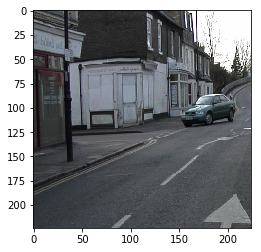

In [55]:
sg = segm_generator(imgs, lbs, 4, train=True)
b_img, b_label = next(sg)
plt.imshow(b_img[0]*0.3+0.4)

In [56]:
def dict_color_label(x):
    l = [code2id[tuple(i)] for i in x]
    l = np.array(l)
    return l

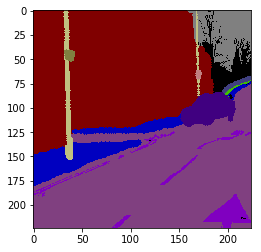

In [57]:
temp = dict_color_label(b_label[0])
plt.imshow(color_label(np.resize(temp, (224,224))))

## Creating Test Set

In [58]:
train_set = imgs[:468]
train_labels = labels_int[:468]

test_set = imgs[468:]
test_labels = labels_int[468:]

In [59]:
len(train_set), len(test_set), len(train_labels), len(test_labels)

(468, 232, 468, 232)

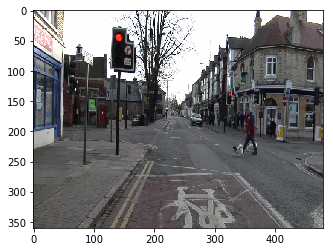

In [60]:
plt.imshow(train_set[462]*0.3+0.4)

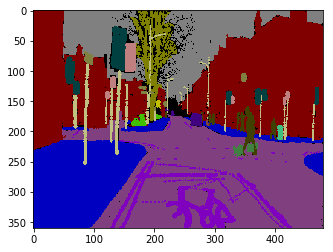

In [61]:
plt.imshow(color_label(train_labels[462]))

In [62]:
train_labels[0].shape

(360, 480)

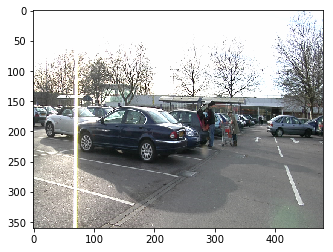

In [63]:
image_number = 230
plt.imshow(train_set[image_number]*0.3+0.4)


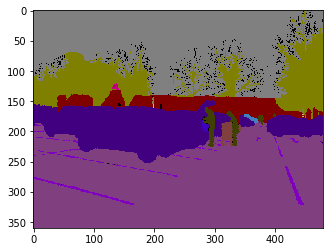

In [64]:
plt.imshow(color_label(train_labels[image_number]))

## Make the Train and Test generators for feeding the data in

In [65]:
train_generator = segm_generator(train_set, train_labels, 3, train=True)
test_generator = segm_generator(test_set, test_labels, 3, train=False)

In [66]:
i,la = next(train_generator)

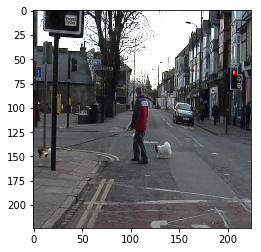

In [67]:
plt.imshow(i[0]*0.3+0.4)

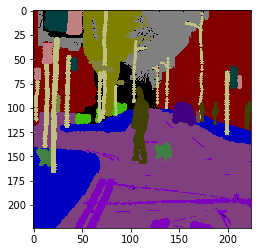

In [68]:
# t = dict_color_label(la[0])
plt.imshow(color_label(np.resize(la[0], (224,224))))

## Make the Unet model

/home/samwit/anaconda3/envs/keras2/lib/python3.5/site-packages/ipykernel_launcher.py:25: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
/home/samwit/anaconda3/envs/keras2/lib/python3.5/site-packages/keras/legacy/layers.py:458: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  name=name)
/home/samwit/anaconda3/envs/keras2/lib/python3.5/site-packages/ipykernel_launcher.py:29: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
/home/samwit/anaconda3/envs/keras2/lib/python3.5/site-packages/ipykernel_launcher.py:33: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concate

In [70]:
model = Model(input=[inputs], output=[conv12])

/home/samwit/anaconda3/envs/keras2/lib/python3.5/site-packages/ipykernel_launcher.py:1: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=[<tf.Tenso...)`
  """Entry point for launching an IPython kernel.


In [71]:
model.compile(optimizer=Adam(lr=1e-5), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [72]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 224, 224, 3)   0                                            
____________________________________________________________________________________________________
conv2d_1 (Conv2D)                (None, 224, 224, 32)  896         input_1[0][0]                    
____________________________________________________________________________________________________
conv2d_2 (Conv2D)                (None, 224, 224, 32)  9248        conv2d_1[0][0]                   
____________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)   (None, 112, 112, 32)  0           conv2d_2[0][0]                   
___________________________________________________________________________________________

In [73]:
#model.fit_generator(train_generator, len(train_set), 20, validation_data=test_generator, nb_val_samples=len(test_set))

In [53]:
hist = model.fit_generator(train_generator, steps_per_epoch=len(train_set), epochs=50, validation_data=test_generator, validation_steps=len(test_set))

Epoch 1/50
468/468 [==============================] - 45s - loss: 0.5311 - acc: 0.8373 - val_loss: 0.6207 - val_acc: 0.8155
Epoch 2/50
468/468 [==============================] - 43s - loss: 0.5127 - acc: 0.8432 - val_loss: 0.6439 - val_acc: 0.8065
Epoch 3/50
468/468 [==============================] - 43s - loss: 0.5175 - acc: 0.8412 - val_loss: 0.6162 - val_acc: 0.8161
Epoch 4/50
468/468 [==============================] - 43s - loss: 0.5072 - acc: 0.8439 - val_loss: 0.6062 - val_acc: 0.8166
Epoch 5/50
468/468 [==============================] - 43s - loss: 0.5031 - acc: 0.8452 - val_loss: 0.6251 - val_acc: 0.8124
Epoch 6/50
468/468 [==============================] - 43s - loss: 0.4986 - acc: 0.8460 - val_loss: 0.6002 - val_acc: 0.8193
Epoch 7/50
468/468 [==============================] - 43s - loss: 0.4950 - acc: 0.8472 - val_loss: 0.6160 - val_acc: 0.8181
Epoch 8/50
468/468 [==============================] - 43s - loss: 0.4946 - acc: 0.8472 - val_loss: 0.6312 - val_acc: 0.8133
Epoch 9/

In [65]:
hist = model.fit_generator(train_generator, steps_per_epoch=len(train_set), epochs=50, validation_data=test_generator, validation_steps=len(test_set))

Epoch 1/50
468/468 [==============================] - 43s - loss: 0.3313 - acc: 0.8920 - val_loss: 0.4758 - val_acc: 0.8610
Epoch 2/50
468/468 [==============================] - 43s - loss: 0.3251 - acc: 0.8940 - val_loss: 0.4524 - val_acc: 0.8669
Epoch 3/50
468/468 [==============================] - 43s - loss: 0.3316 - acc: 0.8917 - val_loss: 0.4730 - val_acc: 0.8630
Epoch 4/50
468/468 [==============================] - 43s - loss: 0.3288 - acc: 0.8925 - val_loss: 0.4632 - val_acc: 0.8632
Epoch 5/50
468/468 [==============================] - 43s - loss: 0.3313 - acc: 0.8917 - val_loss: 0.4479 - val_acc: 0.8693
Epoch 6/50
468/468 [==============================] - 43s - loss: 0.3223 - acc: 0.8942 - val_loss: 0.4657 - val_acc: 0.8626
Epoch 7/50
468/468 [==============================] - 43s - loss: 0.3154 - acc: 0.8963 - val_loss: 0.4934 - val_acc: 0.8550
Epoch 8/50
468/468 [==============================] - 43s - loss: 0.3201 - acc: 0.8950 - val_loss: 0.4587 - val_acc: 0.8657
Epoch 9/

In [67]:
hist = model.fit_generator(train_generator, steps_per_epoch=len(train_set), epochs=200, validation_data=test_generator, validation_steps=len(test_set))

Epoch 1/200
468/468 [==============================] - 43s - loss: 0.2532 - acc: 0.9134 - val_loss: 0.4415 - val_acc: 0.8733
Epoch 2/200
468/468 [==============================] - 43s - loss: 0.2475 - acc: 0.9151 - val_loss: 0.4446 - val_acc: 0.8785
Epoch 3/200
468/468 [==============================] - 43s - loss: 0.2433 - acc: 0.9165 - val_loss: 0.4442 - val_acc: 0.8756
Epoch 4/200
468/468 [==============================] - 43s - loss: 0.2515 - acc: 0.9141 - val_loss: 0.4330 - val_acc: 0.8775
Epoch 5/200
468/468 [==============================] - 43s - loss: 0.2459 - acc: 0.9159 - val_loss: 0.4410 - val_acc: 0.8794
Epoch 6/200
468/468 [==============================] - 43s - loss: 0.2442 - acc: 0.9164 - val_loss: 0.4407 - val_acc: 0.8778
Epoch 7/200
468/468 [==============================] - 43s - loss: 0.2465 - acc: 0.9156 - val_loss: 0.4337 - val_acc: 0.8786
Epoch 8/200
468/468 [==============================] - 43s - loss: 0.2449 - acc: 0.9158 - val_loss: 0.4315 - val_acc: 0.8808


468/468 [==============================] - 43s - loss: 0.1950 - acc: 0.9304 - val_loss: 0.4234 - val_acc: 0.8887
Epoch 67/200
468/468 [==============================] - 43s - loss: 0.1951 - acc: 0.9305 - val_loss: 0.4248 - val_acc: 0.8878
Epoch 68/200
468/468 [==============================] - 43s - loss: 0.1920 - acc: 0.9316 - val_loss: 0.4287 - val_acc: 0.8890
Epoch 69/200
468/468 [==============================] - 43s - loss: 0.1954 - acc: 0.9301 - val_loss: 0.4376 - val_acc: 0.8866
Epoch 70/200
468/468 [==============================] - 43s - loss: 0.1931 - acc: 0.9310 - val_loss: 0.4332 - val_acc: 0.8861
Epoch 71/200
468/468 [==============================] - 43s - loss: 0.1913 - acc: 0.9320 - val_loss: 0.4326 - val_acc: 0.8879
Epoch 72/200
468/468 [==============================] - 43s - loss: 0.1918 - acc: 0.9314 - val_loss: 0.4253 - val_acc: 0.8886
Epoch 73/200
468/468 [==============================] - 43s - loss: 0.1921 - acc: 0.9313 - val_loss: 0.4342 - val_acc: 0.8858
Epoch

468/468 [==============================] - 43s - loss: 0.1455 - acc: 0.9459 - val_loss: 0.4391 - val_acc: 0.8974
Epoch 195/200
468/468 [==============================] - 43s - loss: 0.1442 - acc: 0.9463 - val_loss: 0.4371 - val_acc: 0.8960
Epoch 196/200
468/468 [==============================] - 43s - loss: 0.1448 - acc: 0.9460 - val_loss: 0.4403 - val_acc: 0.8938
Epoch 197/200
468/468 [==============================] - 43s - loss: 0.1447 - acc: 0.9460 - val_loss: 0.4540 - val_acc: 0.8946
Epoch 198/200
468/468 [==============================] - 43s - loss: 0.1450 - acc: 0.9461 - val_loss: 0.4381 - val_acc: 0.8970
Epoch 199/200
468/468 [==============================] - 43s - loss: 0.1475 - acc: 0.9453 - val_loss: 0.4399 - val_acc: 0.8957
Epoch 200/200
468/468 [==============================] - 43s - loss: 0.1444 - acc: 0.9462 - val_loss: 0.4289 - val_acc: 0.8970


In [53]:
hist = model.fit_generator(train_generator, steps_per_epoch=len(train_set), epochs=200, validation_data=test_generator, validation_steps=len(test_set))

Epoch 1/200
468/468 [==============================] - 44s - loss: 0.1459 - acc: 0.9457 - val_loss: 0.4486 - val_acc: 0.8959
Epoch 2/200
468/468 [==============================] - 43s - loss: 0.1463 - acc: 0.9456 - val_loss: 0.4449 - val_acc: 0.8959
Epoch 3/200
468/468 [==============================] - 43s - loss: 0.1442 - acc: 0.9462 - val_loss: 0.4323 - val_acc: 0.8972
Epoch 4/200
468/468 [==============================] - 43s - loss: 0.1448 - acc: 0.9459 - val_loss: 0.4409 - val_acc: 0.8970
Epoch 5/200
468/468 [==============================] - 43s - loss: 0.1448 - acc: 0.9461 - val_loss: 0.4324 - val_acc: 0.8970
Epoch 6/200
468/468 [==============================] - 43s - loss: 0.1426 - acc: 0.9468 - val_loss: 0.4337 - val_acc: 0.8970
Epoch 7/200
468/468 [==============================] - 43s - loss: 0.1465 - acc: 0.9455 - val_loss: 0.4300 - val_acc: 0.8959
Epoch 8/200
468/468 [==============================] - 43s - loss: 0.1421 - acc: 0.9470 - val_loss: 0.4272 - val_acc: 0.8974


468/468 [==============================] - 43s - loss: 0.1318 - acc: 0.9503 - val_loss: 0.4426 - val_acc: 0.8983
Epoch 67/200
468/468 [==============================] - 43s - loss: 0.1304 - acc: 0.9507 - val_loss: 0.4424 - val_acc: 0.8994
Epoch 68/200
468/468 [==============================] - 43s - loss: 0.1318 - acc: 0.9503 - val_loss: 0.4401 - val_acc: 0.8990
Epoch 69/200
468/468 [==============================] - 43s - loss: 0.1311 - acc: 0.9505 - val_loss: 0.4435 - val_acc: 0.8968
Epoch 70/200
468/468 [==============================] - 43s - loss: 0.1322 - acc: 0.9502 - val_loss: 0.4317 - val_acc: 0.8990
Epoch 71/200
468/468 [==============================] - 43s - loss: 0.1336 - acc: 0.9497 - val_loss: 0.4187 - val_acc: 0.8991
Epoch 72/200
468/468 [==============================] - 43s - loss: 0.1309 - acc: 0.9506 - val_loss: 0.4419 - val_acc: 0.8963
Epoch 73/200
468/468 [==============================] - 43s - loss: 0.1304 - acc: 0.9508 - val_loss: 0.4353 - val_acc: 0.8980
Epoch

468/468 [==============================] - 43s - loss: 0.1139 - acc: 0.9564 - val_loss: 0.4541 - val_acc: 0.9007
Epoch 195/200
468/468 [==============================] - 43s - loss: 0.1131 - acc: 0.9566 - val_loss: 0.4567 - val_acc: 0.9009
Epoch 196/200
468/468 [==============================] - 43s - loss: 0.1130 - acc: 0.9568 - val_loss: 0.4515 - val_acc: 0.9015
Epoch 197/200
468/468 [==============================] - 43s - loss: 0.1138 - acc: 0.9564 - val_loss: 0.4596 - val_acc: 0.9013
Epoch 198/200
468/468 [==============================] - 43s - loss: 0.1126 - acc: 0.9569 - val_loss: 0.4539 - val_acc: 0.9008
Epoch 199/200
468/468 [==============================] - 43s - loss: 0.1140 - acc: 0.9563 - val_loss: 0.4613 - val_acc: 0.9010
Epoch 200/200
468/468 [==============================] - 43s - loss: 0.1146 - acc: 0.9561 - val_loss: 0.4528 - val_acc: 0.9017


In [68]:
model.save('Unet-camvid-01a')

In [74]:
model = load_model('Unet-camvid-01b')

/home/samwit/anaconda3/envs/keras2/lib/python3.5/site-packages/keras/engine/topology.py:1242: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  return cls(**config)


In [122]:
model.optimizer.lr = 1e-4
model.fit_generator(train_generator, steps_per_epoch=len(train_set), epochs=2, validation_data=test_generator, validation_steps=len(test_set))

/home/samwit/anaconda3/envs/keras2/lib/python3.5/site-packages/ipykernel_launcher.py:3: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/samwit/anaconda3/envs/keras2/lib/python3.5/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<__main__...., 468, 2, validation_data=<__main__...., validation_steps=232)`
  This is separate from the ipykernel package so we can avoid doing imports until


Epoch 1/2
468/468 [==============================] - 43s - loss: 0.7700 - acc: 0.7800 - val_loss: 0.8635 - val_acc: 0.7552
Epoch 2/2
468/468 [==============================] - 43s - loss: 0.7622 - acc: 0.7823 - val_loss: 0.8279 - val_acc: 0.7632


In [91]:
#model.save('Unet-camvid-01a')

## Some Predictions on the test set

In [89]:
i,la = next(test_generator)
i.shape

(3, 224, 224, 3)

In [90]:
#predictions = model.predict_generator(test_generator, len(test_set))

In [91]:
predictions = model.predict(i)

In [92]:
predictions = np.argmax(predictions, axis=-1)

In [93]:
predictions.shape

(3, 50176)

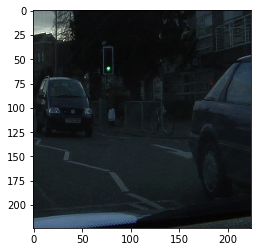

In [80]:
image_number = 1
plt.imshow(i[image_number]*0.3+0.4)

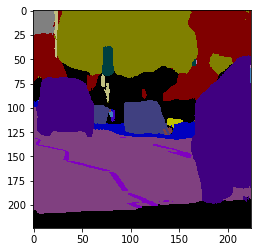

In [81]:
plt.imshow(color_label(np.resize(predictions[image_number], (224,224))))

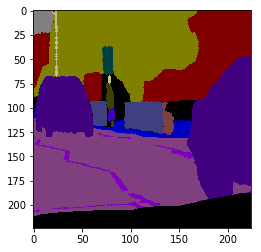

In [82]:
plt.imshow(color_label(np.resize(la[image_number], (224,224))))

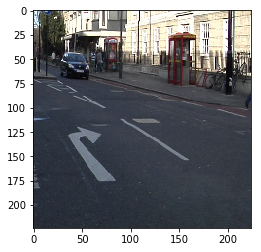

In [83]:
image_number = 0
plt.imshow(i[image_number]*0.3+0.4)

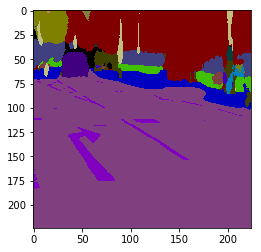

In [84]:
plt.imshow(color_label(np.resize(predictions[image_number], (224,224))))

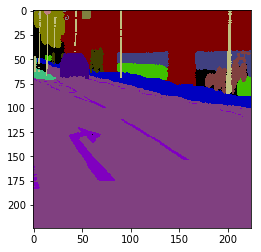

In [85]:
plt.imshow(color_label(np.resize(la[image_number], (224,224))))

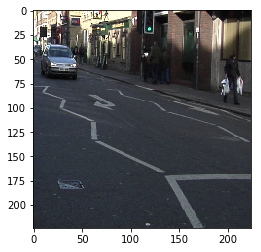

In [86]:
image_number = 2
plt.imshow(i[image_number]*0.3+0.4)

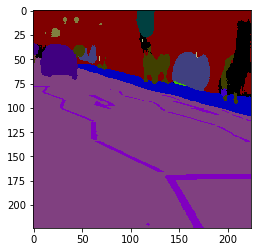

In [87]:
plt.imshow(color_label(np.resize(predictions[image_number], (224,224))))

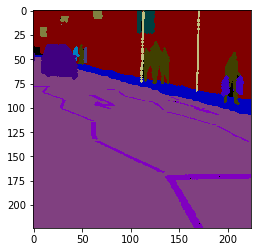

In [88]:
plt.imshow(color_label(np.resize(la[image_number], (224,224))))

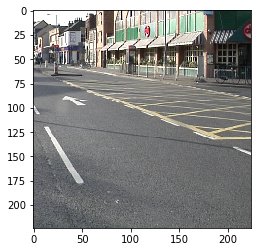

In [94]:
image_number = 1
plt.imshow(i[image_number]*0.3+0.4)

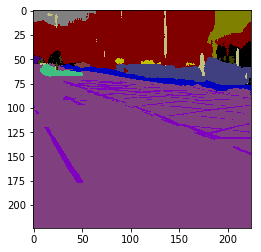

In [95]:
plt.imshow(color_label(np.resize(predictions[image_number], (224,224))))

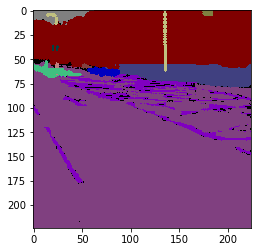

In [96]:
plt.imshow(color_label(np.resize(la[image_number], (224,224))))

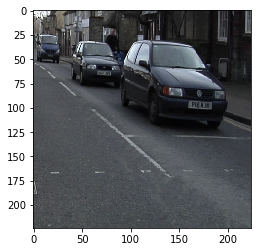

In [97]:
image_number = 0
plt.imshow(i[image_number]*0.3+0.4)

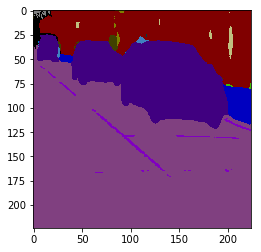

In [98]:
plt.imshow(color_label(np.resize(predictions[image_number], (224,224))))

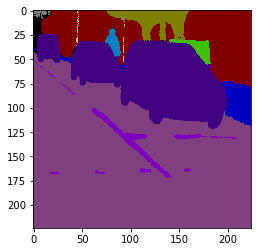

In [99]:
plt.imshow(color_label(np.resize(la[image_number], (224,224))))

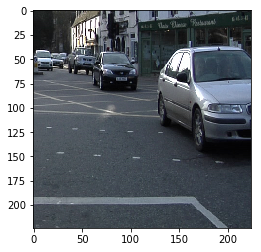

In [100]:
image_number = 2
plt.imshow(i[image_number]*0.3+0.4)

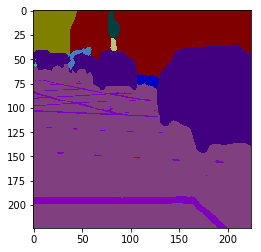

In [101]:
plt.imshow(color_label(np.resize(predictions[image_number], (224,224))))

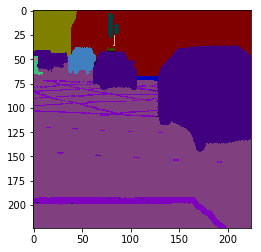

In [102]:
plt.imshow(color_label(np.resize(la[image_number], (224,224))))

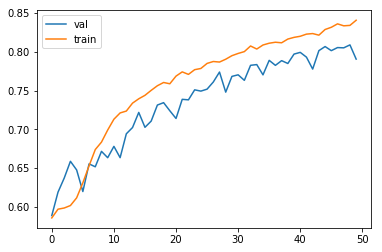

In [60]:
plt.plot(model.history.history['val_acc'])
plt.plot(model.history.history['acc'])
plt.legend(['val', 'train'], loc='upper left')

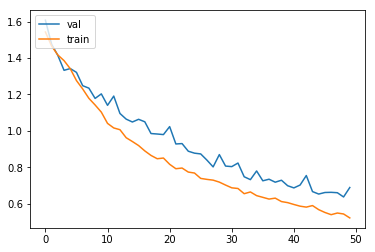

In [61]:
plt.plot(model.history.history['val_loss'])
plt.plot(model.history.history['loss'])
plt.legend(['val', 'train'], loc='upper left')